Esta é uma script em jupyter para fazer pequenas funções e depois passar para a script em python.

In [14]:
import os
import subprocess
import numpy as np
from Bio import SeqIO, SeqFeature, Entrez, AlignIO, ExPASy, SwissProt
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Blast import NCBIXML, NCBIWWW
from Bio.Align.Applications import ClustalwCommandline
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor, DistanceCalculator
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio import Phylo
from matplotlib import pyplot, rc

c:\Users\arafa\miniconda3\envs\labs\lib\site-packages\Bio\Application\__init__.py:39: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


### Análise da sequência e das features presentes no NCBI

Funtion to get gene genbank file

In [3]:
def get_genome(accession, filename = "genome.gb", db="nucleotide",rettype="gbwithparts", email="your_email@example.com", output_dir="genome"):
    """
    Fetches a sequence from NCBI and saves it to a file in the specified output directory.
    
    Args:
        accession (str): NCBI Accession or ID.
        filename (str): File name to save the sequence.
        db (str): NCBI database to query (e.g., "nucleotide", "protein").
        rettype (str): Format of the returned sequence (e.g., "fasta", "gb").
        email (str): User's email for NCBI access.
        output_dir (str): Directory where the file will be saved.
    
    Returns:
        str: Full path to the saved file.
    """
    Entrez.email = email
    os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists
    output_path = os.path.join(output_dir, filename)  # Full path to save file

    try:
        print(f"Fetching data for accession: {accession} from {db} database...")
        handle = Entrez.efetch(db=db, id=accession, rettype=rettype, retmode="text")
        sequence_data = handle.read()
        handle.close()

        # Save the sequence to the output file
        with open(output_path, "w") as file:
            file.write(sequence_data)
        print(f"Sequence saved successfully to {output_path}.")
        return output_path

    except Exception as e:
        print(f"An error occurred: {e}")
        return None


In [25]:
get_genome("NC_000964.3", output_dir="genome")

Fetching data for accession: NC_000964.3 from nucleotide database...
Sequence saved successfully to comS/genome\genome.gb.


'comS/genome\\genome.gb'

Funtion to extract detailed gene info from genbank complete genome file

In [4]:
def extract_gene_features(filename, gene_name, output_file="gene_features_output.txt", output_dir="features"):
    """
    Extracts detailed information for a specific gene or CDS from a GenBank file
    and saves the terminal output to a text file in the specified output directory.

    Args:
        filename (str): Path to the GenBank file.
        gene_name (str): Name, locus tag, or product description of the gene or CDS.
        output_file (str): Name of the output file to save the details.
        output_dir (str): Directory to save the output file.
    """
    try:
        # Ensure the output directory exists
        os.makedirs(output_dir, exist_ok=True)

        # Define the full output path
        output_path = os.path.join(output_dir, output_file)

        # Open a file to save the output
        with open(output_path, "w") as out_file:
            # Read the GenBank file
            record = SeqIO.read(filename, "genbank")

            # Search for matching features
            matches = []
            for feature in record.features:
                qualifiers = feature.qualifiers
                if (
                    "gene" in qualifiers and gene_name in qualifiers["gene"]
                    or "locus_tag" in qualifiers and gene_name in qualifiers["locus_tag"]
                    or "product" in qualifiers and gene_name in qualifiers["product"]
                ):
                    matches.append(feature)

            if matches:
                out_file.write(f"Found {len(matches)} matching feature(s) for '{gene_name}':\n\n")
                for i, feature in enumerate(matches, 1):
                    out_file.write(f"Feature {i}: {feature.type}\n")
                    out_file.write(f"  Location: {feature.location}\n")
                    for key, value in feature.qualifiers.items():
                        # Qualifiers are lists, join values for readability
                        out_file.write(f"  {key.capitalize()}: {', '.join(value)}\n")
                    out_file.write("\n")
            else:
                out_file.write(f"No matching features found for '{gene_name}' in the GenBank file.\n")

        print(f"Details saved to {output_path}.")

    except Exception as e:
        # Handle errors by saving them to the output file
        with open(output_path, "w") as out_file:
            out_file.write(f"An error occurred: {e}\n")
        print(f"An error occurred. Check {output_path} for details.")



In [27]:
extract_gene_features("Genome/genome.gb", "comS")

Details saved to features\gene_features_output.txt.


In [5]:
def extract_gene(genome_file, gene_name, output_dir="extracted_seqs"):
    """
    Extracts a specific gene by name from a GenBank genome file and saves its DNA sequence and translation.
    
    Args:
        genome_file (str): Path to the GenBank file containing the genome.
        gene_name (str): Name of the gene to extract.
        output_dir (str): Directory to save the output files.
        dna_filename (str): Name of the DNA output FASTA file.
        protein_filename (str): Name of the protein output FASTA file.
    
    Returns:
        None
    """
    try:
        # Ensure the output directory exists
        os.makedirs(output_dir, exist_ok=True)
        
        # Define full paths for the output files
        dna_output_path = os.path.join(output_dir, gene_name + "_dna.fasta")
        protein_output_path = os.path.join(output_dir, gene_name + "_protein.fasta")
        
        # Parse the GenBank file
        with open(genome_file, "r") as gb_file:
            genome_record = SeqIO.read(gb_file, "genbank")
        
        # Search for the gene in the genome annotations
        for feature in genome_record.features:
            if feature.type == "CDS" and "gene" in feature.qualifiers:
                if gene_name in feature.qualifiers["gene"]:
                    # Extract the gene sequence
                    gene_seq = feature.extract(genome_record.seq)
                    
                    # Extract the protein translation, if available
                    protein_translation = feature.qualifiers.get("translation", [None])[0]
                    
                    # Write the DNA sequence to the DNA FASTA file
                    with open(dna_output_path, "w") as dna_file:
                        dna_file.write(f">{gene_name} [NC_000964.3] DNA sequence\n{gene_seq}\n")
                    print(f"{gene_name} DNA sequence saved to {dna_output_path}.")
                    
                    # Write the protein translation to the protein FASTA file
                    if protein_translation:
                        with open(protein_output_path, "w") as protein_file:
                            protein_file.write(f">{gene_name} [NC_000964.3] Protein translation\n{protein_translation}\n")
                        print(f"{gene_name} protein translation saved to {protein_output_path}.")
                    else:
                        print(f"No protein translation available for {gene_name}.")
                    
                    return
        
        print(f"Gene {gene_name} not found in the genome.")
    
    except Exception as e:
        print(f"An error occurred: {e}")


In [8]:
extract_gene(genome_file="Genome/genome.gb", gene_name="comS")

comS DNA sequence saved to extracted_seqs\comS_dna.fasta.
comS protein translation saved to extracted_seqs\comS_protein.fasta.


# Análise de Estrtura de proteinas (ProtParagram)

Função para análise de composição

In [6]:
def plot_amino_acid_composition(fasta_file, output_dir="ProtParagram", output_file="amino_acid_composition.png"):
    """
    Generates a bar chart showing the amino acid composition of a protein sequence
    from a FASTA file and saves it in the specified directory.

    Parameters:
    fasta_file (str): Path to the FASTA file containing the protein sequence.
    output_dir (str): Directory where the plot will be saved.
    output_file (str): Name of the output file for the plot.
    """
    # Create output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, output_file)

    # Read the protein sequence from the FASTA file
    with open(fasta_file, "r") as handle:
        record = next(SeqIO.parse(handle, "fasta"))  # Read the first sequence from the file
        sequence = str(record.seq)
    
    # Analyze the protein sequence
    analysis = ProteinAnalysis(sequence)
    composition = analysis.get_amino_acids_percent()

    # Sort amino acids
    amino_acids = sorted(composition.keys())
    percentages = [composition[aa] * 100 for aa in amino_acids]  # Convert to percentage

    # Define colors for each bar
    colors = pyplot.cm.tab20(range(len(amino_acids)))  # Use a colormap with 20 distinct colors

    # Create bar chart
    pyplot.figure(figsize=(10, 6))
    bars = pyplot.bar(amino_acids, percentages, color=colors)
    pyplot.xlabel('Amino Acids')
    pyplot.ylabel('Percentage (%)')
    pyplot.title('Amino Acid Composition')

    # Add percentage labels above each bar
    for bar, percentage in zip(bars, percentages):
        yval = bar.get_height()
        pyplot.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{percentage:.2f}%', ha='center', va='bottom')

    # Save the plot in the specified directory
    pyplot.savefig(output_path, dpi=300, bbox_inches='tight')
    pyplot.close()

    print(f"Plot saved at: {output_path}")


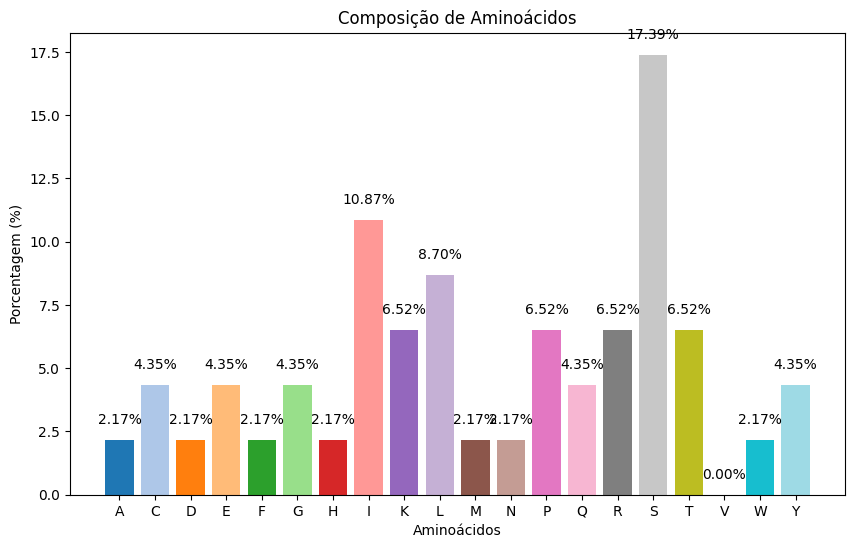

In [6]:
plot_amino_acid_composition("comS/extracted_seqs/comS_protein.fasta")

Função para análise de propiedades de proteinas

In [7]:
def plot_protein_properties(fasta_file, output_dir="ProtParagram", output_file="protein_properties.png"):
    """
    Generates a radar plot showing protein properties from a FASTA file and saves it in the specified directory.
    
    Parameters:
    fasta_file (str): Path to the FASTA file containing the protein sequence.
    output_dir (str): Directory where the plot will be saved.
    output_file (str): Name of the output file for the plot.
    """
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, output_file)
    
    with open(fasta_file, "r") as handle:
        record = next(SeqIO.parse(handle, "fasta"))
        sequence = str(record.seq)
    
    analysis = ProteinAnalysis(sequence)
    
    properties = {
        'Molecular Weight (kDa)': analysis.molecular_weight() / 1000,
        'Isoelectric Point': analysis.isoelectric_point(),
        'Instability': analysis.instability_index(),
        'Hydrophobicity': analysis.gravy(),
        'Aromaticity (%)': analysis.aromaticity() * 100
    }
    
    labels = list(properties.keys())
    values = list(properties.values())
    values += values[:1]
    angles = np.linspace(0, 2 * np.pi, len(labels) + 1, endpoint=True)
    
    fig, ax = pyplot.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.4)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    
    for angle, value, label in zip(angles, values, labels):
        ax.text(angle, value, f'{value:.2f}', horizontalalignment='center', size=10, color='black', weight='semibold')

    pyplot.title('Protein Properties')
    pyplot.savefig(output_path, dpi=300, bbox_inches='tight')
    pyplot.close()
    print(f"Plot saved at: {output_path}")

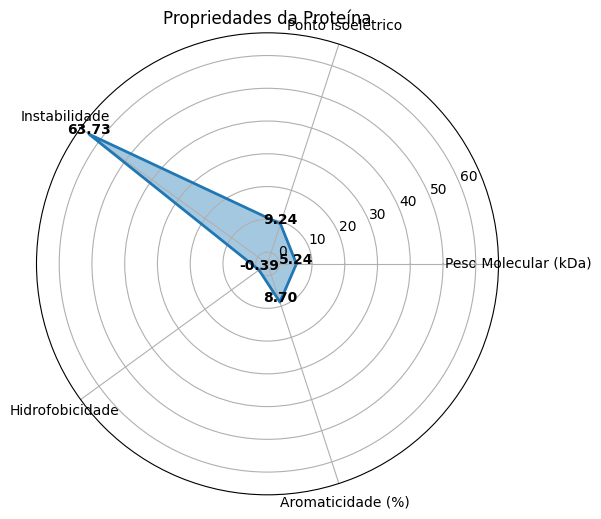

In [7]:
plot_protein_properties("comS/extracted_seqs/comS_protein.fasta")

### Análise de homologias por BLAST

Função para fazer um NCBI blast apartir de um file (pode-se escolher o tipo de blast, database e outros parâmetros)

In [8]:
def blast(file_name, file_format = "fasta", program = "blastn", database = "nt", e_value = 0.05, hitlist_size=10000):
    """
    Performs a BLAST search for a sequence contained in a file.
    
    Parameters:
        file_name (str): Name of the file containing the sequence.
        file_format (str): Format of the file (default: 'fasta').
        program (str): BLAST program to use (default: 'blastn').
        database (str): Database to search (default: 'nt').
        e_value (float): E-value threshold for the search (default: 0.05).
        hitlist_size (int): Number of hits to return (default: 100).
    
    Returns:
        A handle with the BLAST results, or None in case of an error.
    """

    try:
        # Open the sequence file and read it using Biopython
        record = SeqIO.read(open(file_name), format=file_format)

        print("BLASTing...")
        # Perform the BLAST search using NCBIWWW.qblast
        result_handle = NCBIWWW.qblast(program, database, record.format("fasta"), expect=e_value, hitlist_size=hitlist_size)

        # Print success message and return the BLAST results handle
        print("BLAST completed successfully.")
        return result_handle

    except Exception as e:
        # Catch any exceptions and print an error message
        print(f"Error running BLAST: {e}")
        return None

Função que utiliza função blast, mas guardar o output num file.

In [9]:
def get_blast(file_name, output_name="blast_result", output_dir="blast_output",
            file_format="fasta", program="blastn", database="nt",
            e_value=0.05, hitlist_size=10000):
    """
    Performs a BLAST search using the `blast` function and saves the results to a file.
    
    Parameters:
        file_name (str): Name of the file containing the sequence.
        output_name (str): Name of the file to save the results.
        Other parameters are the same as those in the `blast` function.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
    output_path = os.path.join(output_dir, output_name)  # Full path to the output file

    result_handle = blast(file_name, file_format, program, database, e_value, hitlist_size)

    if result_handle is not None:
        try:
            # Save the results to an XML file
            with open(f"{output_path}.xml", "w") as save_file:
                save_file.write(result_handle.read())
                print(f"Results saved to {output_name}.xml.")

        except Exception as e:
            print(f"Error saving the results: {e}")

        finally:
            result_handle.close()

    

Teste da função *get_blast* 

In [71]:
get_blast("comS/extracted_seqs/comS_dna.fasta", output_name ="comS_dna")

BLASTing...
BLAST completed successfully.
Results saved to comS_dna.xml.


In [12]:
get_blast("comS/extracted_seqs/comS_protein.fasta", output_name ="comS_protein",program = "blastp", database = "nr")

BLASTing...
BLAST completed successfully.
Results saved to comS_protein.xml.


Função de extract de sequências Homólogas

In [11]:
def get_and_save_homologous(
    file_name, query_fasta, output_file="sequences.fasta", output_dir="homologs", log_file_name = "homologous_log.txt",
    exclude=None, e_value_thresh=0.05, identity_thresh=90, coverage_thresh=0.7, n_seq=20
):
    """
    Extracts homologous sequences from BLAST results and saves them to a FASTA file.

    Args:
        file_name (str): Path to the BLAST XML result file.
        query_fasta (str): Path to the query sequence FASTA file.
        output_file (str): Name of the FASTA file to save.
        output_dir (str): Directory to save the FASTA file.
        exclude (list): List of species or keywords to exclude.
        e_value_thresh (float): Threshold for E-value significance.
        identity_thresh (float): Minimum percentage identity for significant hits.
        n_seq (int): Maximum number of sequences to extract.
        coverage_thresh (float): Minimum fraction of query sequence covered by the alignment (0 to 1).

    Returns:
        str: Path to the saved FASTA file.
    """
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)
    output_log = os.path.join(output_dir, log_file_name)
    
    with open(output_log, "w") as log_file:
        # Read the query sequence from the FASTA file
        with open(query_fasta, "r") as fasta_handle:
            query_record = SeqIO.read(fasta_handle, "fasta")
            query_sequence = str(query_record.seq)

        if not query_sequence:
            raise ValueError("Query sequence could not be read from the FASTA file.")

        # Initialize the dictionary with the query sequence
        sequences = {"Query": query_sequence}
        added_species = set()

        log_file.write(f"Starting extraction with criteria: E-value < {e_value_thresh}, Identity > {identity_thresh}%, Coverage > {coverage_thresh}\n")

        # Parse the BLAST XML file
        with open(file_name) as result_handle:
            blast_record = NCBIXML.read(result_handle)

        query_length = len(query_sequence)
        total_alignments = len(blast_record.alignments)
        log_file.write(f"Total alignments found: {total_alignments}\n")

        # Iterate through alignments
        for alignment in blast_record.alignments:
            if len(sequences) >= n_seq:
                break

            if exclude and any(term.lower() in alignment.title.lower() for term in exclude):
                continue

            for hsp in alignment.hsps:
                identity = (hsp.identities / hsp.align_length) * 100
                coverage = (hsp.query_end - hsp.query_start + 1) / query_length

                if hsp.expect < e_value_thresh and identity > identity_thresh and 0 <= coverage <= 1:
                    title_parts = alignment.title.split("|")[-1]
                    species_name = title_parts.split("[")[-1].split("]")[0]
                    formatted_species_name = "_".join(species_name.split()[:2])
                    sequence_header = f"{formatted_species_name}|{alignment.title.split('|')[-2]}"

                    if formatted_species_name not in added_species:
                        sequences[sequence_header] = hsp.sbjct
                        added_species.add(formatted_species_name)

                        log_file.write(f"Added: {sequence_header} | Identity: {identity:.2f}% | "
                                       f"E-value: {hsp.expect:.2e} | Coverage: {coverage:.2f}\n")

                        if len(sequences) >= n_seq:
                            log_file.write("\nExtraction complete: Maximum sequence count reached.\n")
                            break

        log_file.write("\nExtraction complete.\n")
        log_file.write(f"Total sequences extracted: {len(sequences)}\n")

        # Save sequences to a FASTA file
        output_path = os.path.join(output_dir, output_file)
        records = [SeqRecord(Seq(seq), id=species, description="") for species, seq in sequences.items()]
        SeqIO.write(records, output_path, "fasta")

        log_file.write(f"Sequences saved to {output_path}.\n")
        return output_path



get_and_save_homologous("comS/blast_output/comS_dna.xml", query_fasta="comS/extracted_seqs/comS_dna.fasta", output_file= "comS_dna_homologs.fasta",
                                        exclude=[], e_value_thresh=0.05, identity_thresh=90, coverage_thresh=0.7)

In [6]:
get_and_save_homologous("comS/blast_output/comS_protein.xml", query_fasta="comS/extracted_seqs/comS_protein.fasta", output_file= "comS_prot_homologs.fasta",
                                        exclude=["subtilis"], e_value_thresh=0.05, identity_thresh=90, coverage_thresh=0.7)

'homologs\\comS_prot_homologs.fasta'

### Alinhamento múltiplo e filogenia

In [10]:
def run_clustalO(input_file, output_file="aligned_sequences.aln", output_dir="clustal_output"):
    """
    Runs Clustal Omega for multiple sequence alignment.
    
    Args:
        input_file (str): Path to the input FASTA file.
        output_file (str): Name of the output alignment file.
        output_dir (str): Directory to save the alignment result.
    
    Returns:
        str: Full path to the output alignment file.
    """
    os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist
    output_path = os.path.join(output_dir, output_file)  # Full path to the output file

    clustalo_exe = "_clustal-omega-1.2.2-win64\\clustalo"  # Path to Clustal Omega executable

    # Command to run Clustal Omega
    command = [
        clustalo_exe,
        "--infile", input_file,
        "--outfile", output_path,
        "--outfmt", "clu",  # Output format: Clustal
        "--force"  # Overwrite existing files if necessary
    ]

    try:
        # Run the command
        result = subprocess.run(command, capture_output=True, text=True, check=True)
        print("Clustal Omega alignment completed successfully.")
        print(result.stdout)
        return output_path
    except subprocess.CalledProcessError as e:
        print("Error during Clustal Omega execution:")
        print(e.stderr)
        raise



In [29]:
run_clustalO(input_file="comS/homologs/comS_dna_homologs.fasta", output_file="comS_dna.aln")

Clustal Omega alignment completed successfully.



In [24]:
run_clustalO(input_file="comS/homologs/comS_prot_homologs.fasta", output_file="comS_protein.aln")

Clustal Omega alignment completed successfully.



Função para costrução de árvores apartir do output do clustalOmega

In [16]:
def build_trees(file_name, file_type="clustal", gene="", matrix="blosum62", output_dir="tree_output"):
    """
    Builds phylogenetic trees (UPGMA and NJ) from a sequence alignment file.
    
    Args:
        file_name (str): Path to the input alignment file.
        file_type (str): Format of the input alignment file (e.g., "clustal", "fasta").
        matrix (str): Scoring matrix for distance calculation (default: "blosum62").
        output_dir (str): Directory to save intermediate files and outputs (default: "tree_output").
    
    Returns:
        None: Displays the trees as ASCII diagrams in the console.
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    output_upgma = os.path.join(output_dir, f'{gene}_upgma.nwk')

    try:
        # Read the alignment file
        alignment = AlignIO.read(file_name, file_type)
        
        # Calculate pairwise distances
        calculator = DistanceCalculator(matrix)
        dm = calculator.get_distance(alignment)
        
        # Construct trees using UPGMA
        constructor = DistanceTreeConstructor()
        upgma_tree = constructor.upgma(dm)

        # Escreve a árvore UPGMA em um arquivo no formato Newick
        Phylo.write(upgma_tree, output_upgma, 'newick')


    except Exception as e:
        print(f"An error occurred: {e}")

In [17]:
build_trees(
    gene="comS_dna",
    file_name="comS/clustal_output/comS_dna.aln",
    file_type="clustal",
    matrix="blosum62",
    output_dir="tree_output"
)

An error occurred: [Errno 2] No such file or directory: 'clustal_output/comS_dna.aln'


In [39]:
build_trees(
    gene="comS_prot",
    file_name="comS/clustal_output/comS_protein.aln",
    file_type="clustal",
    matrix="blosum62",
    output_dir="tree_output"
)

In [20]:
def highlight_homo_clade_and_remove_inner(upgma_file, output_dir="tree_output", output_file="upgma_tree.png"):
    """
    Reads the UPGMA phylogenetic tree, removes 'Inner' labels, and highlights the clade with the genus 'Homo'.
    
    Args:
        upgma_file (str): Path to the UPGMA tree file (Newick format).
        output_dir (str): Directory where the plot will be saved.
        output_file (str): Name of the output file for the plot.
    """
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, output_file)
    
    # Read the tree
    upgmatree = Phylo.read(upgma_file, 'newick')

    # Remove 'Inner' labels from UPGMA tree clades
    for clade in upgmatree.find_clades():
        if clade.name and 'Inner' in clade.name:
            clade.name = ""

    # Find and highlight the clade with the genus "Homo" in the UPGMA tree
    for clade in upgmatree.find_clades():
        if clade.name and 'Query' in clade.name:
            clade.color = 'orange'
            clade.name = '*** ' + clade.name + ' ***'

    # Adjust figure size
    fig, ax = pyplot.subplots(figsize=(22, 10), dpi=100)
    rc('font', size=12)
    Phylo.draw(upgmatree, do_show=False, axes=ax)
    pyplot.title("UPGMA Tree")

    # Save the tree in the specified directory
    pyplot.savefig(output_path, dpi=300, bbox_inches='tight')
    pyplot.close()
    print(f"UPGMA tree saved at: {output_path}")


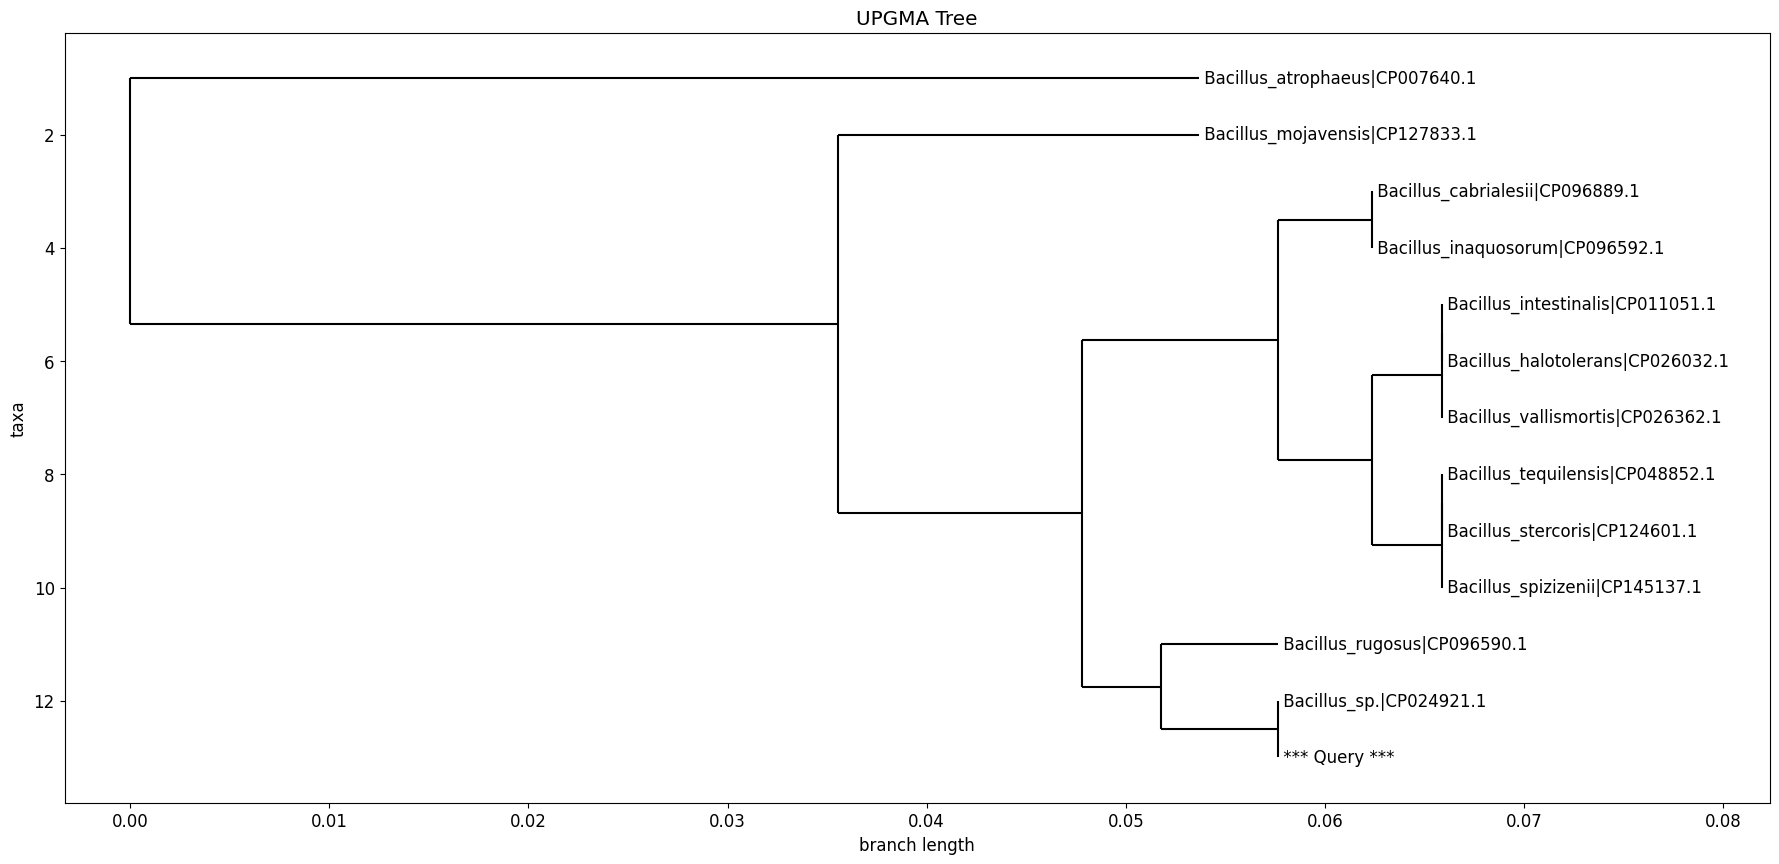

In [128]:
highlight_homo_clade_and_remove_inner('comS/tree_output/comS_dna_upgma.nwk')

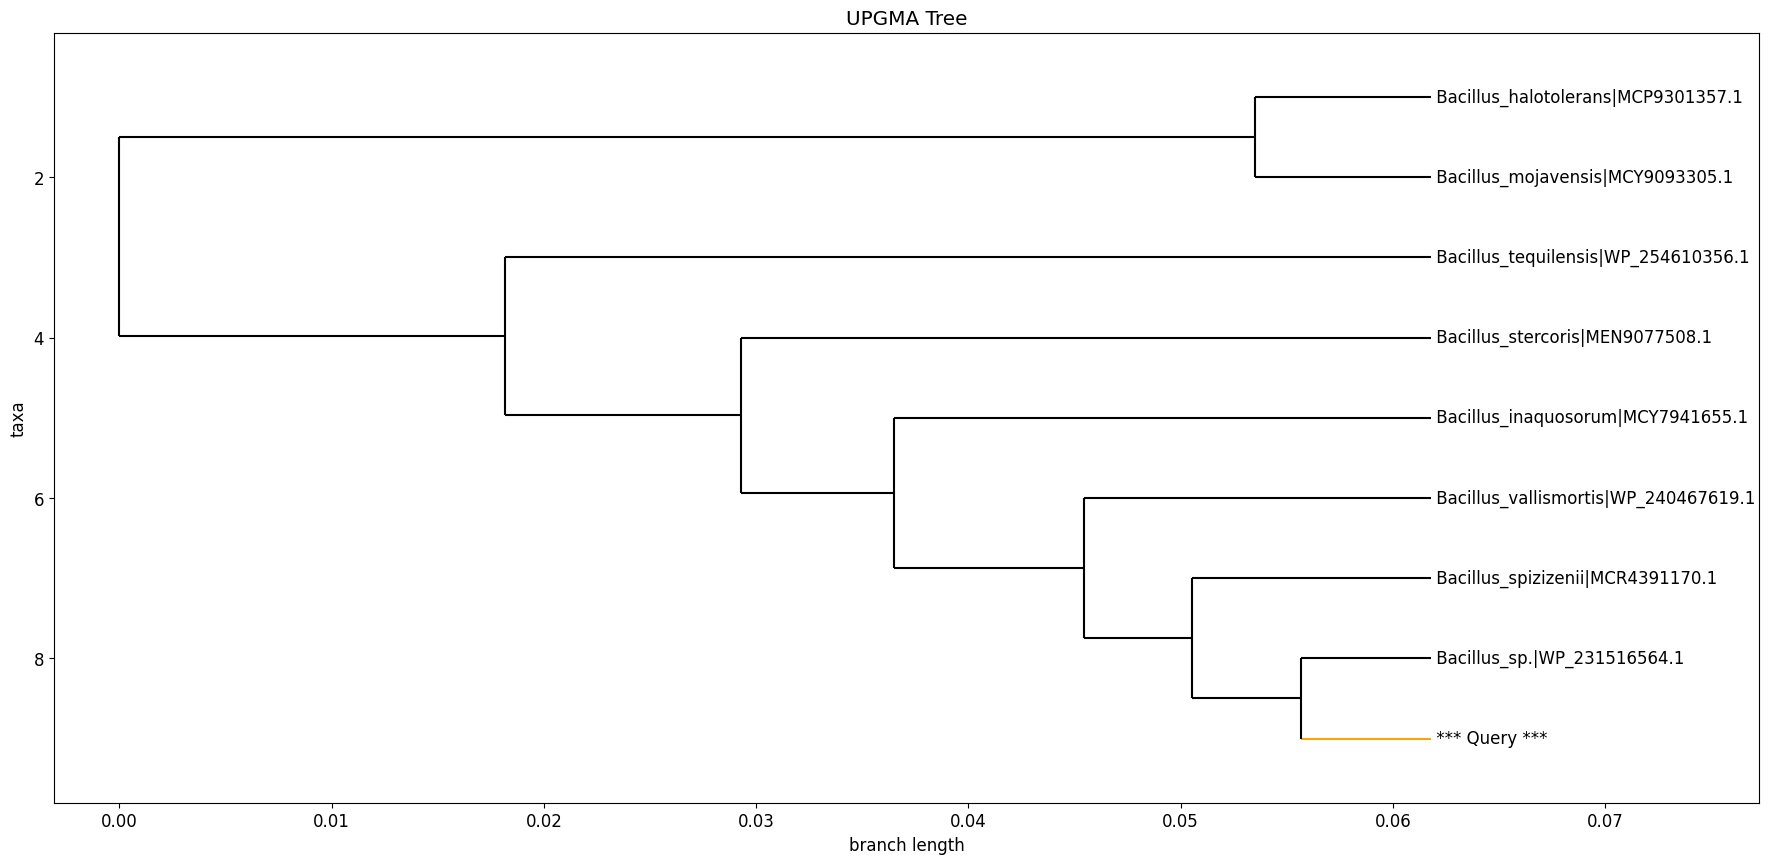

In [129]:
highlight_homo_clade_and_remove_inner('comS/tree_output/comS_prot_upgma.nwk')

# Pipeline de Análise

In [21]:
def full_analysis(annotated_RefSeq, genes, species):
    """
    Perform a full analysis pipeline for the specified genes and species.

    Args:
        annotated_RefSeq (str): Path to the annotated RefSeq file.
        genes (list): List of genes to analyze.
        species (str): Species name.
    """
    # Step 1: Retrieve the genome and get "exclude" for blast filtering
    get_genome(annotated_RefSeq)
    genus, species = species.split()
    
    # Step 2: Process each gene
    for gene in genes:
        # Create a directory for the gene
        os.makedirs(gene, exist_ok=True)

        # Extract gene features and save them in the "features" directory
        extract_gene_features(
            filename="genome/genome.gb",
            gene_name=gene,
            output_dir=f"{gene}/features"
        )

        # Extract gene sequences and save them in the "extracted_seqs" directory
        extract_gene(
            genome_file="genome/genome.gb",
            gene_name=gene,
            output_dir=f"{gene}/extracted_seqs"
        )

        #Perform a aminoacid composition analysis
        plot_amino_acid_composition(
            f"{gene}/extracted_seqs/{gene}_protein.fasta",
            output_dir=f"{gene}/ProtParagram",
            output_file="amino_acid_composition.png")

        #Perform a protein properties analysis
        plot_protein_properties(
            f"{gene}/extracted_seqs/{gene}_protein.fasta",
            output_dir=f"{gene}/ProtParagram", 
            output_file="protein_properties.png")

        # Perform BLAST for DNA and protein sequences, saving results in the "blast_output" directory
        get_blast(
            file_name=f"{gene}/extracted_seqs/{gene}_dna.fasta",
            output_name=f"{gene}_dna",
            output_dir=f"{gene}/blast_output"
        )
        get_blast(
            file_name=f"{gene}/extracted_seqs/{gene}_protein.fasta",
            output_name=f"{gene}_protein",
            program="blastp",
            database="nr",
            output_dir=f"{gene}/blast_output"
        )

        # Extract homologous sequences for DNA and protein, saving results in the "homologs" directory
        get_and_save_homologous(
            file_name=f"{gene}/blast_output/{gene}_dna.xml",
            query_fasta=f"{gene}/extracted_seqs/{gene}_dna.fasta",
            output_file=f"{gene}_dna_homologs.fasta",
            exclude=[species],
            output_dir=f"{gene}/homologs",
            log_file_name = f"{gene}_dna_homologs_log.txt"
        )
        get_and_save_homologous(
            file_name=f"{gene}/blast_output/{gene}_protein.xml",
            query_fasta=f"{gene}/extracted_seqs/{gene}_protein.fasta",
            output_file=f"{gene}_prot_homologs.fasta",
            exclude=[species],
            output_dir=f"{gene}/homologs",
            log_file_name = f"{gene}_prot_homologs_log.txt"
        )
        # Extract homologous sequences for DNA and protein only from other genus
        get_and_save_homologous(
            file_name=f"{gene}/blast_output/{gene}_dna.xml",
            query_fasta=f"{gene}/extracted_seqs/{gene}_dna.fasta",
            output_file=f"{gene}_dna_homologs_far.fasta",
            exclude=[genus, species],
            output_dir=f"{gene}/homologs",
            log_file_name = f"{gene}_dna_homologs_far_log.txt"
        )
        get_and_save_homologous(
            file_name=f"{gene}/blast_output/{gene}_protein.xml",
            query_fasta=f"{gene}/extracted_seqs/{gene}_protein.fasta",
            output_file=f"{gene}_prot_homologs_far.fasta",
            exclude=[genus, species],
            output_dir=f"{gene}/homologs",
            log_file_name = f"{gene}_prot_homologs_far_log.txt"
        )

        # Perform multiple sequence alignment using ClustalO, saving results in the "clustal_output" directory
        run_clustalO(
            input_file=f"{gene}/homologs/{gene}_dna_homologs.fasta",
            output_file=f"{gene}_dna.aln",
            output_dir=f"{gene}/clustal_output"
        )
        run_clustalO(
            input_file=f"{gene}/homologs/{gene}_prot_homologs.fasta",
            output_file=f"{gene}_protein.aln",
            output_dir=f"{gene}/clustal_output"
        )

        # Build phylogenetic trees for DNA and protein alignments, saving results in the "tree_output" directory
        build_trees(
            gene=f"{gene}_dna",
            file_name=f"{gene}/clustal_output/{gene}_dna.aln",
            output_dir=f"{gene}/tree_output"
        )
        build_trees(
            gene=f"{gene}_prot",
            file_name=f"{gene}/clustal_output/{gene}_protein.aln",
            output_dir=f"{gene}/tree_output"
        )

        highlight_homo_clade_and_remove_inner(
            upgma_file=f"{gene}/tree_output/{gene}_dna_upgma.nwk",
            output_dir=f"{gene}/tree_output",
            output_file=f"{gene}_dna_upgma.png"
        )

        highlight_homo_clade_and_remove_inner(
            upgma_file=f"{gene}/tree_output/{gene}_prot_upgma.nwk",
            output_dir=f"{gene}/tree_output",
            output_file=f"{gene}_protein_upgma.png"
        )


In [22]:
full_analysis("NC_000964.3", ["comS", "sigB", "spo0A", "ftsZ"], "Bacillus subtilis")

Fetching data for accession: NC_000964.3 from nucleotide database...
Sequence saved successfully to genome\genome.gb.
Details saved to comS/features\gene_features_output.txt.
comS DNA sequence saved to comS/extracted_seqs\comS_dna.fasta.
comS protein translation saved to comS/extracted_seqs\comS_protein.fasta.
Plot saved at: comS/ProtParagram\amino_acid_composition.png
Plot saved at: comS/ProtParagram\protein_properties.png
BLASTing...
BLAST completed successfully.
Results saved to comS_dna.xml.
BLASTing...
BLAST completed successfully.
Results saved to comS_protein.xml.
Clustal Omega alignment completed successfully.

Clustal Omega alignment completed successfully.

UPGMA tree saved at: comS/tree_output\comS_dna_upgma.png
UPGMA tree saved at: comS/tree_output\comS_protein_upgma.png
Details saved to sigB/features\gene_features_output.txt.
sigB DNA sequence saved to sigB/extracted_seqs\sigB_dna.fasta.
sigB protein translation saved to sigB/extracted_seqs\sigB_protein.fasta.
Plot saved a